In [37]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

import os, PIL, random, pathlib

import numpy as np
np.random.seed(1)

import tensorflow as tf
tf.random.set_seed(1)

In [39]:
data_dir = '015_licence_plate'
data_dir = pathlib.Path(data_dir)

pictures_paths = list(data_dir.glob('*'))
pictures_paths = [str(path) for path in pictures_paths]
pictures_paths[:3]

['015_licence_plate/000008250_沪G1CE81.jpg',
 '015_licence_plate/000015082_云G86LR6.jpg',
 '015_licence_plate/000004721_鄂U71R9F.jpg']

In [41]:
image_count = len(list(pictures_paths))

print('图片总数为: ', image_count)

图片总数为:  13675


In [43]:
all_label_names = [path.split('_')[-1].split('.')[0] for path in pictures_paths] # 以_切分字符串 取最后一个 以.分割文件名和扩展名 取第一个 得到车牌号
all_label_names[:3]

['沪G1CE81', '云G86LR6', '鄂U71R9F']

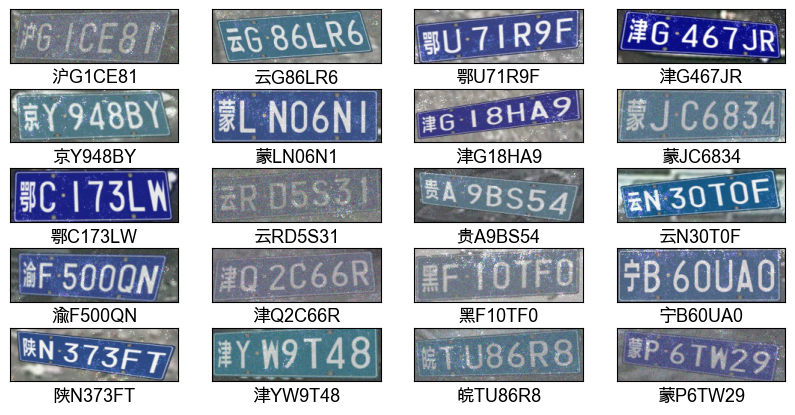

In [45]:
plt.figure(figsize=(10, 5))

for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    images = plt.imread(pictures_paths[i])
    plt.imshow(images)

    plt.xlabel(all_label_names[i], fontsize=13)

plt.show()

In [49]:
char_enum = ["京","沪","津","渝","冀","晋","蒙","辽","吉","黑","苏","浙","皖","闽","赣","鲁",\
              "豫","鄂","湘","粤","桂","琼","川","贵","云","藏","陕","甘","青","宁","新","军","使"]
number = [str(i) for i in range(0, 10)]
alphabet = [chr(i) for i in range(65, 91)]

char_set = char_enum + number + alphabet
char_set_len = len(char_set)
label_name_len = len(all_label_names[0])

def text2vec(text):
    vector = np.zeros([label_name_len, char_set_len])
    for i, c in enumerate(text):
        idx = char_set.index(c)
        vector[i][idx] = 1.0
    return vector

all_labels = [text2vec(i) for i in all_label_names]

In [51]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [50, 200])
    return image/255.0

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [55]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

path_ds = tf.data.Dataset.from_tensor_slices(pictures_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(all_labels)

image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
image_label_ds

<_ZipDataset element_spec=(TensorSpec(shape=(50, 200, 1), dtype=tf.float32, name=None), TensorSpec(shape=(7, 69), dtype=tf.float64, name=None))>

In [57]:
train_ds = image_label_ds.take(5000).shuffle(5000)
val_ds = image_label_ds.take(5000).shuffle(1000)

In [59]:
BATCH_SIZE = 16

train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 50, 200, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7, 69), dtype=tf.float64, name=None))>

In [67]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 200, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(1000, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(label_name_len * char_set_len),
    layers.Reshape([label_name_len, char_set_len]),
    layers.Softmax()
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 48, 198, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 22, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 11, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 33792)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │    33,793,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 483)            │       483,483 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 69)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 7, 69)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,295,299 (130.83 MB)

 Trainable params: 34,295,299 (130.83 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
initial_learning_rate = 1e-3

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=50,
    decay_rate=0.96,
    staircase=True)

optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [71]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [73]:
epochs = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 169ms/step - accuracy: 0.0747 - loss: 3.3656 - val_accuracy: 0.2099 - val_loss: 3.1219
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 164ms/step - accuracy: 0.2897 - loss: 2.6587 - val_accuracy: 0.5406 - val_loss: 1.7764
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 168ms/step - accuracy: 0.4863 - loss: 1.7804 - val_accuracy: 0.7279 - val_loss: 1.0890
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 165ms/step - accuracy: 0.6168 - loss: 1.2790 - val_accuracy: 0.8366 - val_loss: 0.7254
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 169ms/step - accuracy: 0.7000 - loss: 0.9850 - val_accuracy: 0.8939 - val_loss: 0.5008
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 167ms/step - accuracy: 0.7564 - loss: 0.7965 - val_accuracy: 0.9299 - val_loss: 0.3840
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 171ms/step - accuracy: 0.7925 - loss: 0.6714 - val_accuracy: 0.9489 - val_loss: 0.3012
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 166ms/step - accuracy: 0.8209 - loss: 0

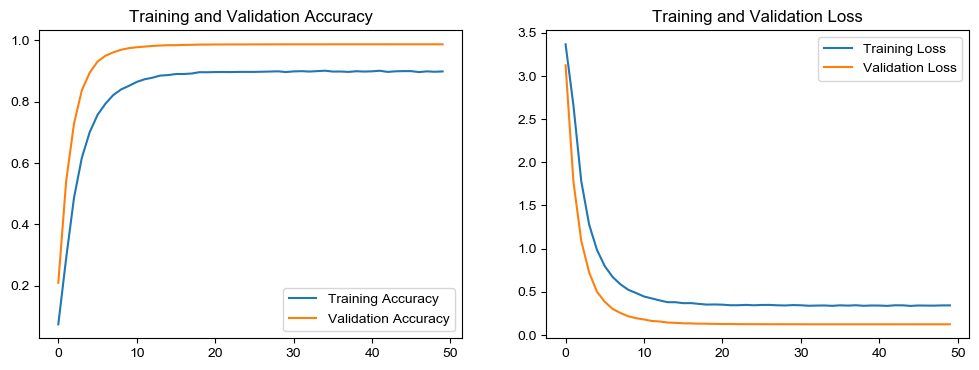

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [79]:
model.save('15_model.h5')

new_model = tf.keras.models.load_model('15_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


2025-08-19 09:57:36.631153: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


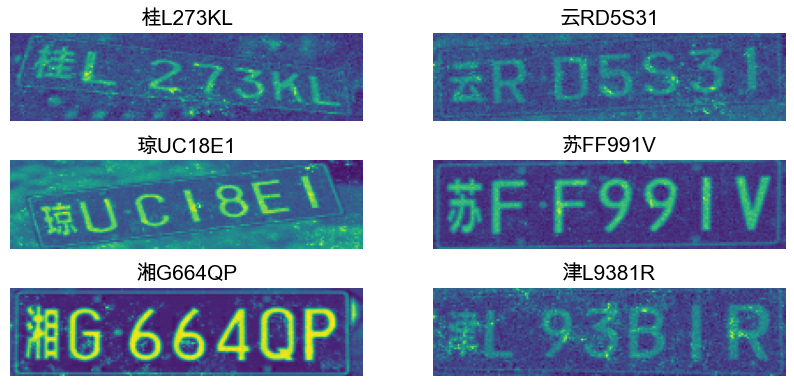

In [85]:
def vec2text(vec):
    text = []
    for i, c in enumerate(vec):
        text.append(char_set[c])
    return ''.join(text)

plt.figure(figsize=(10, 8))

for images, labels in val_ds.take(1):
    for i in range(6):
        ax = plt.subplot(5, 2, i+1)
        
        plt.imshow(images[i])
        
        img_array = tf.expand_dims(images[i], 0)

        predictions = model.predict(img_array)
        plt.title(vec2text(np.argmax(predictions, axis=2)[0]), fontsize=15)

        plt.axis('off')